1. Importar librerías

In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import mlflow
import mlflow.sklearn
import pickle
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, auc
from sklearn.utils import resample
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from openpyxl import Workbook

2. Cargar datos

In [324]:
df = pd.read_excel("C:\\Users\\Valentina Molina\\Documents\\repositorios\\Proyecto_II\\datos\\Bas_de_datos_riesgos_original_30.09.2025.xlsx")

3. Limpieza de datos

In [325]:
for col in df.columns:
    print(col)

Proyecto_CD
Proyecto_DS
UEN_DS
NombreEmpleado_DS
ApellidoEmpleado_DS
Severidad_DS
Riesgo_CD
Estado_DS
Creacion_DT
Actualizacion_DT
CantidadSeveridad_NM
CantidadMaterializada_NM
Insercion_DT
ValorInterno_VR
ValorCliente_VR
NombreRiesgo_DS
Causa_DS
DetalleCausa_DS
Fuente_DS
DescripcionRiesgo_DS
FechaIdentificacion_DT
PlanAccion_DS
FechaSeguimiento_DT
ObservacionSeguimiento_DS
CantidadSeguimientos_NM
EsfuerzoSeguimiento_NM
Periocidad_DS
Cliente_DS
PRY_REQUIERE_RIESGOS
Tipo_Proyecto
Metodologia
AgenteGenerador_DS


In [326]:
df = df.drop(columns=["Proyecto_DS", "UEN_DS", "NombreEmpleado_DS", "ApellidoEmpleado_DS", "Creacion_DT", 
                      "Actualizacion_DT", "CantidadSeveridad_NM", "Insercion_DT", "NombreRiesgo_DS", "Fuente_DS", "DescripcionRiesgo_DS",
                      "FechaIdentificacion_DT", "PlanAccion_DS", "ObservacionSeguimiento_DS", "CantidadSeguimientos_NM",
                      "EsfuerzoSeguimiento_NM", "Periocidad_DS", "Cliente_DS", "PRY_REQUIERE_RIESGOS", "Tipo_Proyecto", "Metodologia"])

In [327]:
df.head()

,Proyecto_CD,Severidad_DS,Riesgo_CD,Estado_DS,CantidadMaterializada_NM,ValorInterno_VR,ValorCliente_VR,Causa_DS,DetalleCausa_DS,FechaSeguimiento_DT,AgenteGenerador_DS
0,10468,NaN,NaN,NO VIGENTE,0,0,0,NaN,NaN,NaT,NaN
1,11051,NaN,NaN,NO VIGENTE,0,0,0,NaN,NaN,NaT,NaN
2,11405,Riesgo Alto,5548.0,VIGENTE,0,0,0,Controles del proceso,Insuficiencia-Deficiencia,2025-06-25,Gerente de Servicio
3,11405,Riesgo Alto,5548.0,VIGENTE,0,0,0,Controles del proceso,Insuficiencia-Deficiencia,2025-07-24,Gerente de Servicio
4,11405,Riesgo Alto,5548.0,VIGENTE,0,0,0,Controles del proceso,Insuficiencia-Deficiencia,2025-08-13,Gerente de Servicio


In [328]:
df = df[df["Estado_DS"] != "NO VIGENTE"]

In [329]:
df["Estado_DS"].unique()

array(['VIGENTE'], dtype=object)

In [330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7822 entries, 2 to 10411
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Proyecto_CD               7822 non-null   int64         
 1   Severidad_DS              7822 non-null   object        
 2   Riesgo_CD                 7822 non-null   float64       
 3   Estado_DS                 7822 non-null   object        
 4   CantidadMaterializada_NM  7822 non-null   int64         
 5   ValorInterno_VR           7822 non-null   int64         
 6   ValorCliente_VR           7822 non-null   int64         
 7   Causa_DS                  7822 non-null   object        
 8   DetalleCausa_DS           6178 non-null   object        
 9   FechaSeguimiento_DT       7735 non-null   datetime64[ns]
 10  AgenteGenerador_DS        7822 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 733.3+ KB


In [331]:
columnas_categoricas=["Severidad_DS","Estado_DS","Causa_DS","DetalleCausa_DS", "AgenteGenerador_DS"]
df[columnas_categoricas]=df[columnas_categoricas].astype("category")

In [332]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7822 entries, 2 to 10411
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Proyecto_CD               7822 non-null   int64         
 1   Severidad_DS              7822 non-null   category      
 2   Riesgo_CD                 7822 non-null   float64       
 3   Estado_DS                 7822 non-null   category      
 4   CantidadMaterializada_NM  7822 non-null   int64         
 5   ValorInterno_VR           7822 non-null   int64         
 6   ValorCliente_VR           7822 non-null   int64         
 7   Causa_DS                  7822 non-null   category      
 8   DetalleCausa_DS           6178 non-null   category      
 9   FechaSeguimiento_DT       7735 non-null   datetime64[ns]
 10  AgenteGenerador_DS        7822 non-null   category      
dtypes: category(5), datetime64[ns](1), float64(1), int64(4)
memory usage: 468.4 KB


4. Creación de nuevas variables

In [333]:
riesgos_materializados = (
    df.groupby("Riesgo_CD")
    .apply(lambda x: any((x["ValorInterno_VR"] > 0) | (x["ValorCliente_VR"] > 0)))
    .reset_index(name="alguna_vez_materializado")
)

df = df.merge(riesgos_materializados, on="Riesgo_CD", how="left")
df["materializado_global"] = np.where(df["alguna_vez_materializado"], 1, 0)

In [334]:
def marcar_materializacion_30d(grupo):
    fechas = grupo["FechaSeguimiento_DT"].values.astype('datetime64[ns]')
    interno = grupo["ValorInterno_VR"].fillna(0).values
    cliente = grupo["ValorCliente_VR"].fillna(0).values
    resultado = []
    
    for i, f in enumerate(fechas):
        fecha_limite = f + np.timedelta64(30, 'D')
        hay_evento = np.any(
            (fechas > f)
            & (fechas <= fecha_limite)
            & ((interno > 0) | (cliente > 0))
        )
        resultado.append(hay_evento)
    
    grupo["materializado_30d"] = resultado
    return grupo

# ✅ Aplicar la función a cada riesgo
df = df.groupby("Riesgo_CD", group_keys=False).apply(marcar_materializacion_30d)


df["materializado_30d"] = np.where(df["materializado_30d"], 1, 0)

In [335]:
print(df.columns.tolist())

['Proyecto_CD', 'Severidad_DS', 'Riesgo_CD', 'Estado_DS', 'CantidadMaterializada_NM', 'ValorInterno_VR', 'ValorCliente_VR', 'Causa_DS', 'DetalleCausa_DS', 'FechaSeguimiento_DT', 'AgenteGenerador_DS', 'alguna_vez_materializado', 'materializado_global', 'materializado_30d']


In [336]:
df["valor_acumulado"] = df["ValorInterno_VR"].fillna(0) + df["ValorCliente_VR"].fillna(0)

df2 = df.dropna(subset=["FechaSeguimiento_DT", "Severidad_DS", "materializado_30d"])

# Convertir a categorías y binario
mapa_severidad = {
    "Riesgo Bajo": 1,
    "Riesgo Medio": 2,
    "Riesgo Significativo": 3,
    "Riesgo Alto": 4,
    "Riesgo Crítico": 5
}
df2["Severidad_NUM"] = df2["Severidad_DS"].map(mapa_severidad)
df2["materializado_30d"] = df2["materializado_30d"].astype(int)

In [337]:
df2.head()

,Proyecto_CD,Severidad_DS,Riesgo_CD,Estado_DS,CantidadMaterializada_NM,ValorInterno_VR,ValorCliente_VR,Causa_DS,DetalleCausa_DS,FechaSeguimiento_DT,AgenteGenerador_DS,alguna_vez_materializado,materializado_global,materializado_30d,valor_acumulado,Severidad_NUM
0,11405,Riesgo Alto,5548.0,VIGENTE,0,0,0,Controles del proceso,Insuficiencia-Deficiencia,2025-06-25,Gerente de Servicio,False,0,0,0,4
1,11405,Riesgo Alto,5548.0,VIGENTE,0,0,0,Controles del proceso,Insuficiencia-Deficiencia,2025-07-24,Gerente de Servicio,False,0,0,0,4
2,11405,Riesgo Alto,5548.0,VIGENTE,0,0,0,Controles del proceso,Insuficiencia-Deficiencia,2025-08-13,Gerente de Servicio,False,0,0,0,4
3,11405,Riesgo Bajo,3592.0,VIGENTE,0,0,0,Legislación,Desconocimiento,2021-03-17,Proceso,False,0,0,0,1
4,11405,Riesgo Bajo,3592.0,VIGENTE,0,0,0,Legislación,Desconocimiento,2021-04-27,Proceso,False,0,0,0,1


5. Análisis descriptivo y gráfico

In [338]:
print("\nResumen estadístico de variables numéricas:")
df2.select_dtypes(include=["number"]).describe().T


Resumen estadístico de variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Proyecto_CD,7735.0,12502.459470,476.077615,11405.0,12224.0,12735.0,12847.0,13052.0
Riesgo_CD,7735.0,4417.572851,906.897778,1979.0,4014.0,4614.0,5149.0,5707.0
CantidadMaterializada_NM,7735.0,0.549838,2.295658,0.0,0.0,0.0,0.0,21.0
ValorInterno_VR,7735.0,14576.311829,413393.108686,0.0,0.0,0.0,0.0,23555600.0
ValorCliente_VR,7735.0,7810.291920,327979.310460,0.0,0.0,0.0,0.0,19070000.0
materializado_global,7735.0,0.071622,0.257878,0.0,0.0,0.0,0.0,1.0
materializado_30d,7735.0,0.006464,0.080145,0.0,0.0,0.0,0.0,1.0
valor_acumulado,7735.0,22386.603749,557975.953993,0.0,0.0,0.0,0.0,24000000.0


In [339]:
print("\nResumen de variables categóricas:")
df2.select_dtypes(include=["category"]).describe().T


Resumen de variables categóricas:


,count,unique,top,freq
Severidad_DS,7735,5,Riesgo Significativo,3200
Estado_DS,7735,1,VIGENTE,7735
Causa_DS,7735,19,Seguridad,2006
DetalleCausa_DS,6143,19,Insuficiencia-Deficiencia,3455
AgenteGenerador_DS,7735,18,Recursos/Insumos/Tecnología,2313
Severidad_NUM,7735,5,3,3200


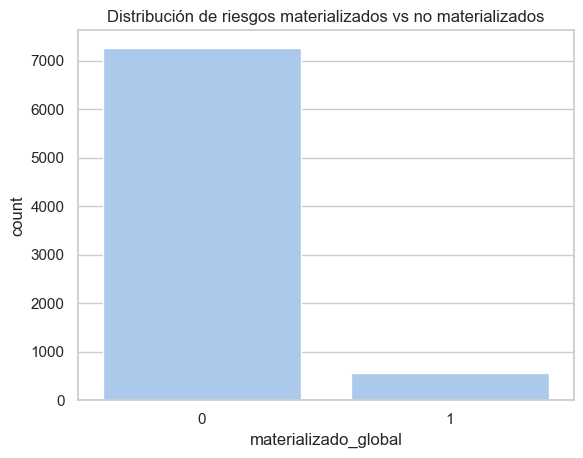

In [340]:
sns.countplot(x="materializado_global", data=df)
plt.title("Distribución de riesgos materializados vs no materializados")
plt.show()

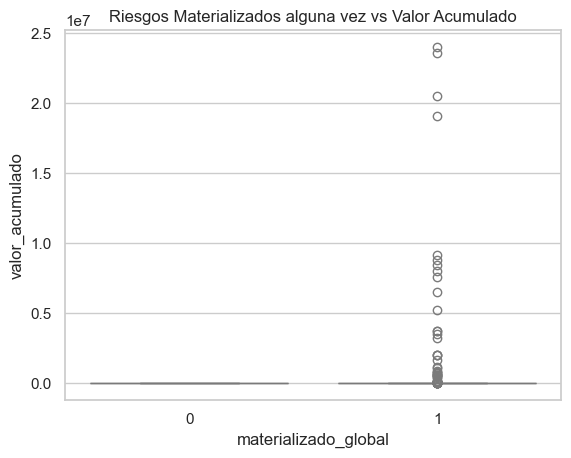

In [341]:
sns.boxplot(x="materializado_global", y="valor_acumulado", data=df2)
plt.title("Riesgos Materializados alguna vez vs Valor Acumulado")
plt.show()

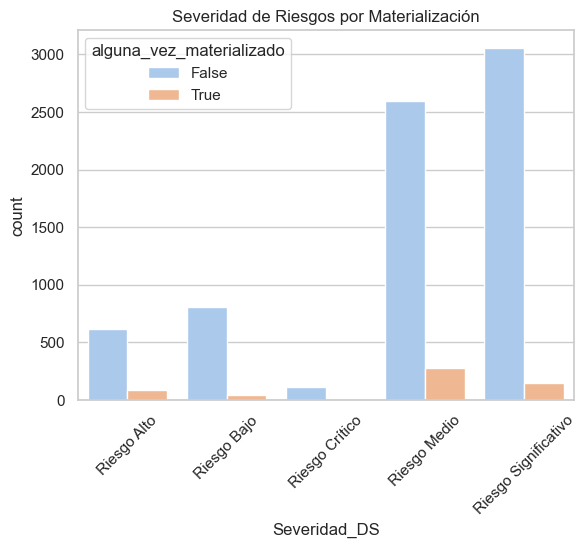

In [342]:
sns.countplot(x="Severidad_DS", hue="alguna_vez_materializado", data=df2)
plt.title("Severidad de Riesgos por Materialización")
plt.xticks(rotation=45)
plt.show()

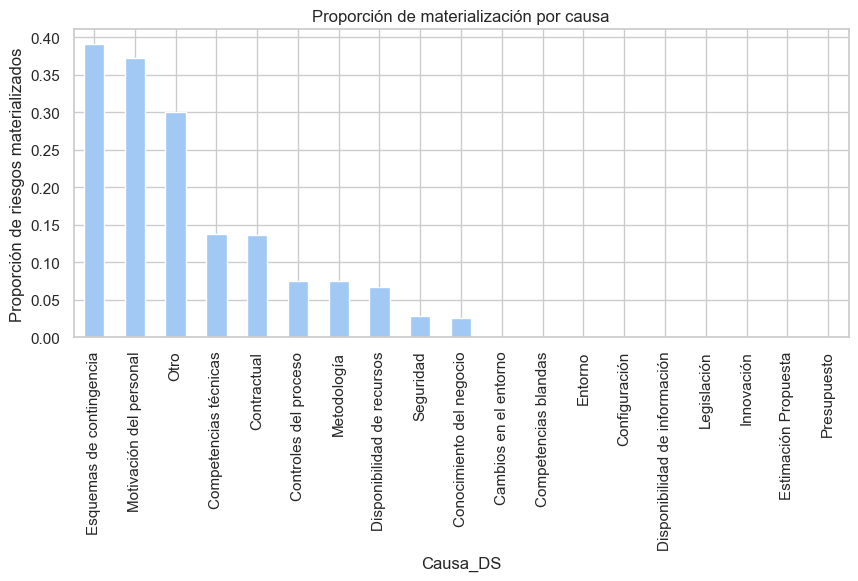

In [343]:
materializacion_por_causa = df.groupby("Causa_DS")["materializado_global"].mean().sort_values(ascending=False)
materializacion_por_causa.plot(kind="bar", figsize=(10,4))
plt.title("Proporción de materialización por causa")
plt.ylabel("Proporción de riesgos materializados")
plt.show()

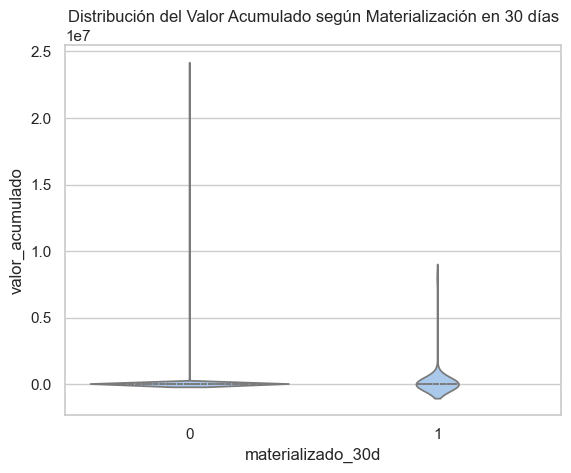

In [344]:
sns.violinplot(x="materializado_30d", y="valor_acumulado", data=df2, inner="quartile")
plt.title("Distribución del Valor Acumulado según Materialización en 30 días")
plt.show()

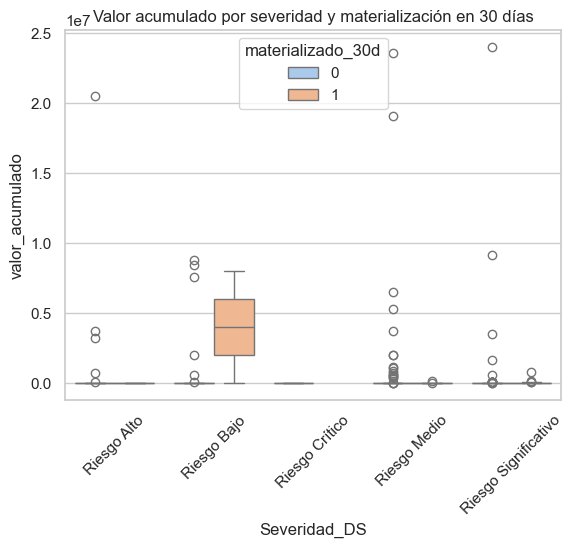

In [345]:
sns.boxplot(x="Severidad_DS", y="valor_acumulado", hue="materializado_30d", data=df2)
plt.title("Valor acumulado por severidad y materialización en 30 días")
plt.xticks(rotation=45)
plt.show()

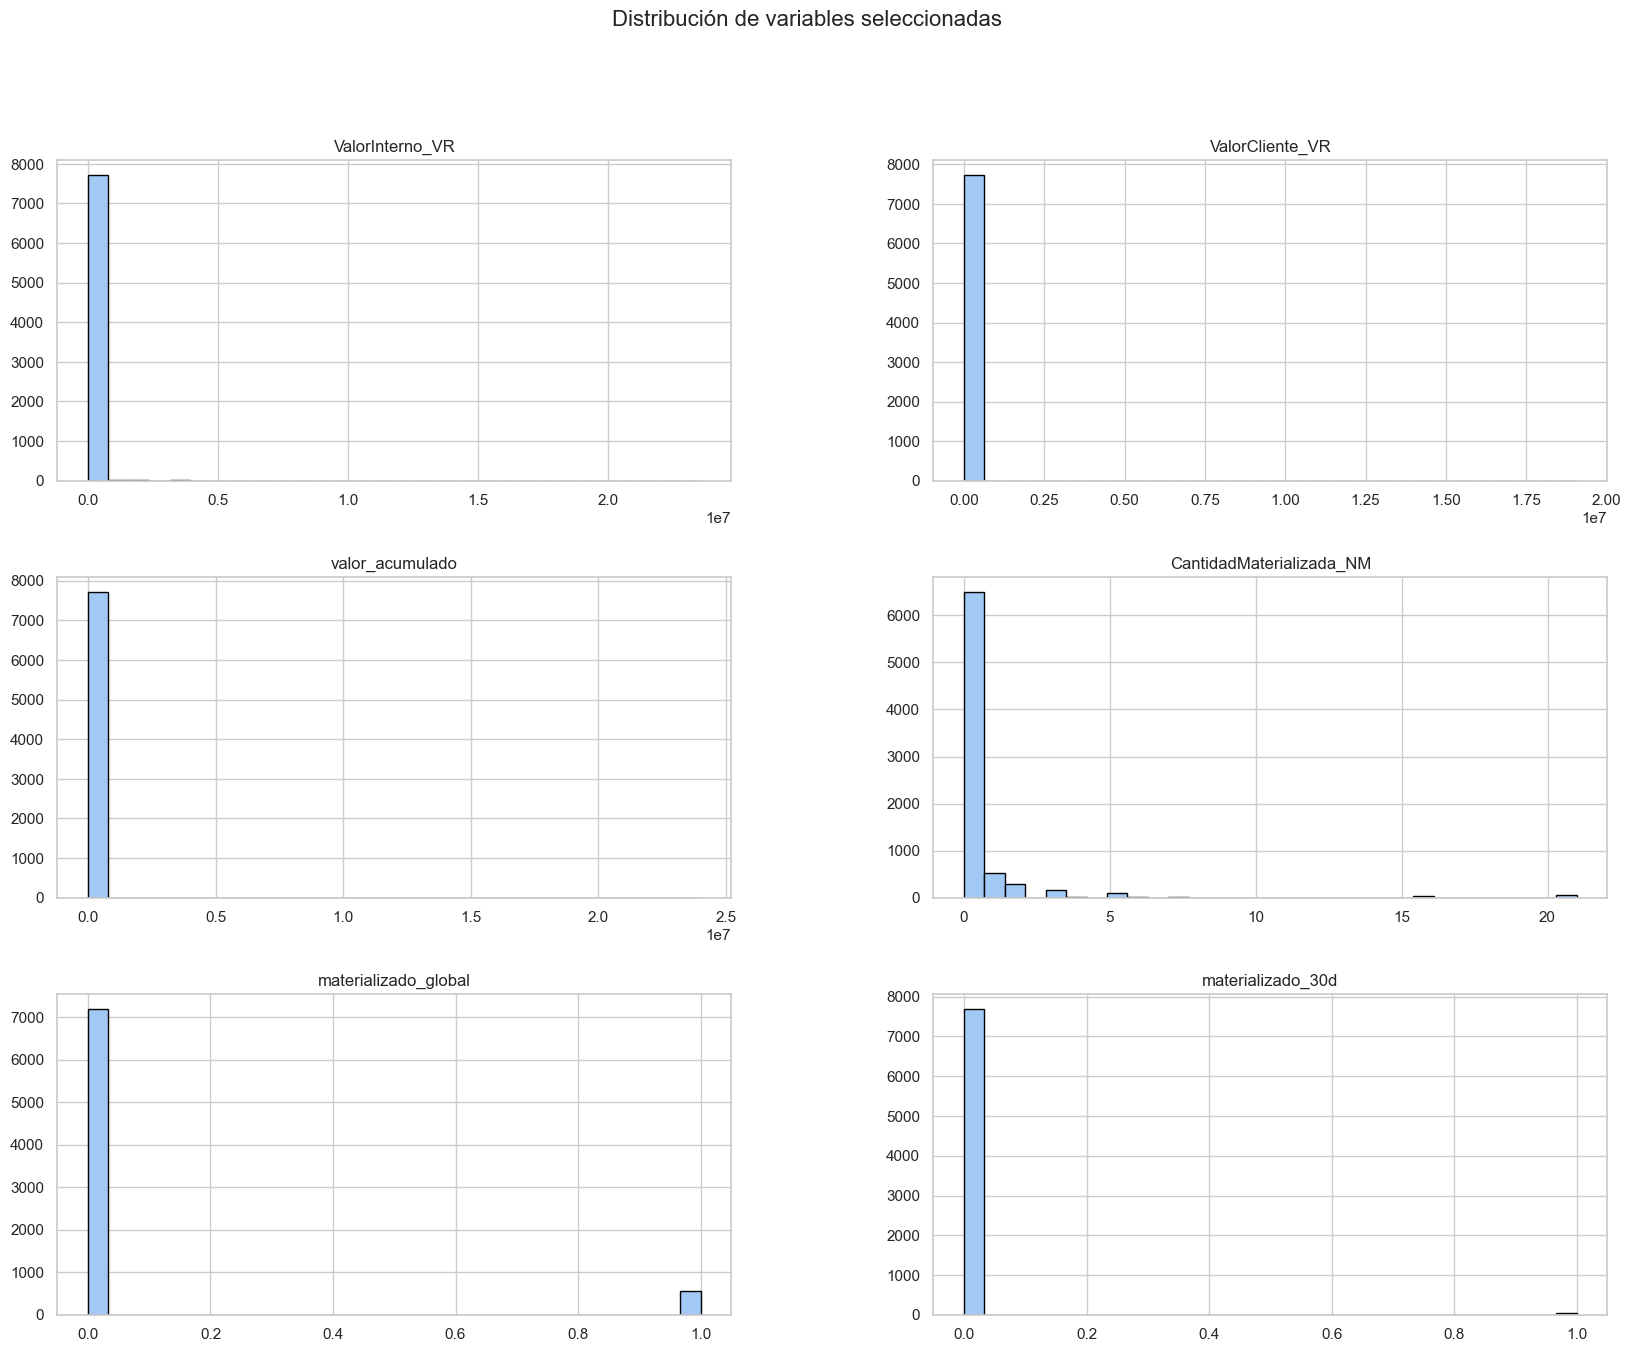

In [346]:
columnas = ["ValorInterno_VR", "ValorCliente_VR", "valor_acumulado", "CantidadMaterializada_NM", "materializado_global", "materializado_30d"]
df2[columnas].hist(bins=30, figsize=(20,15), edgecolor="black")
plt.suptitle("Distribución de variables seleccionadas", fontsize=16)
plt.show()

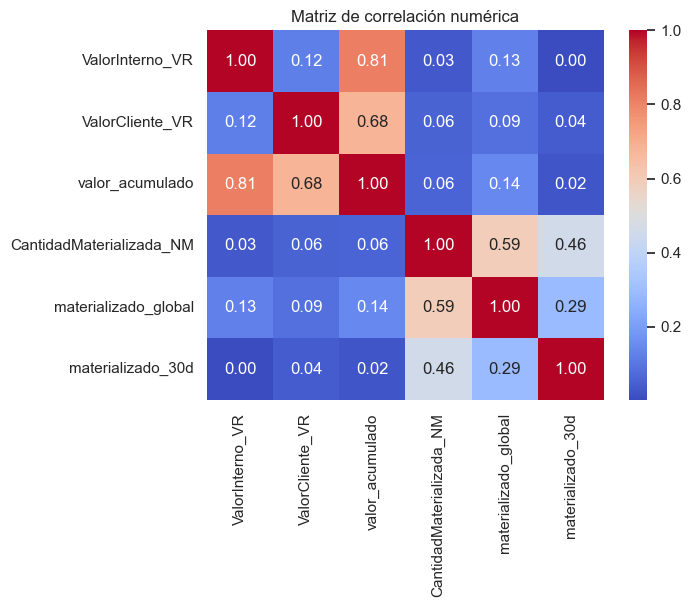

In [347]:
columnas = ["ValorInterno_VR", "ValorCliente_VR", "valor_acumulado", "CantidadMaterializada_NM", "materializado_global", "materializado_30d"]
sns.heatmap(df2[columnas].corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación numérica")
plt.show()

6. División de datos

In [348]:
X = df2[["Severidad_NUM", "valor_acumulado"]]
y = df2["materializado_30d"]

In [349]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)
print("Distribución en y_train:")
print(y_train.value_counts(normalize=True))
print("Distribución en y_test:")
print(y_test.value_counts(normalize=True))

Tamaño del conjunto de entrenamiento: (6188, 2)
Tamaño del conjunto de prueba: (1547, 2)
Distribución en y_train:
materializado_30d
0    0.993536
1    0.006464
Name: proportion, dtype: float64
Distribución en y_test:
materializado_30d
0    0.993536
1    0.006464
Name: proportion, dtype: float64


7. Modelo Random Forest

7.1. Sin balanceo

In [350]:
modelo_rf = RandomForestClassifier(
    n_estimators=100,     
    random_state=42,      
    n_jobs=-1             
)

modelo_rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [351]:
y_pred = modelo_rf.predict(X_test)

In [352]:
print("Matriz de confusión (modelo sin balanceo):")
print(confusion_matrix(y_test, y_pred))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

Matriz de confusión (modelo sin balanceo):
[[1536    1]
 [  10    0]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1537
           1       0.00      0.00      0.00        10

    accuracy                           0.99      1547
   macro avg       0.50      0.50      0.50      1547
weighted avg       0.99      0.99      0.99      1547



7.2. Balanceado en datos de entrenamiento y prueba en datos reales

7.2.1. Oversampling aleatorio

In [353]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

print("Distribución después del oversampling:")
print(y_train_ros.value_counts())

Distribución después del oversampling:
materializado_30d
0    6148
1    6148
Name: count, dtype: int64


In [354]:
modelo_rf_ros = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
modelo_rf_ros.fit(X_train_ros, y_train_ros)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [355]:
y_pred_ros = modelo_rf_ros.predict(X_test)

In [356]:
print("\nMatriz de confusión (Oversampling aleatorio):")
print(confusion_matrix(y_test, y_pred_ros))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_ros, digits=3))


Matriz de confusión (Oversampling aleatorio):
[[1380  157]
 [   9    1]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.994     0.898     0.943      1537
           1      0.006     0.100     0.012        10

    accuracy                          0.893      1547
   macro avg      0.500     0.499     0.478      1547
weighted avg      0.987     0.893     0.937      1547



7.2.2. Smote

In [357]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("Distribución después de aplicar SMOTE:")
print(y_train_sm.value_counts())

Distribución después de aplicar SMOTE:
materializado_30d
0    6148
1    6148
Name: count, dtype: int64


In [358]:
modelo_rf_sm = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
modelo_rf_sm.fit(X_train_sm, y_train_sm)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [359]:
y_pred_sm = modelo_rf_sm.predict(X_test)

In [360]:
print("\nMatriz de confusión (SMOTE):")
print(confusion_matrix(y_test, y_pred_sm))
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred_sm, digits=3))


Matriz de confusión (SMOTE):
[[1379  158]
 [  10    0]]

Reporte de clasificación:
              precision    recall  f1-score   support

           0      0.993     0.897     0.943      1537
           1      0.000     0.000     0.000        10

    accuracy                          0.891      1547
   macro avg      0.496     0.449     0.471      1547
weighted avg      0.986     0.891     0.936      1547



7.2.3. Ajustar class_weight

In [361]:
modelo_rf_balw = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

modelo_rf_balw.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [362]:
probs = modelo_rf_balw.predict_proba(X_test)[:, 1]

In [363]:
# Predicciones estándar con umbral 0.5
y_pred_default = (probs >= 0.5).astype(int)

In [364]:
print("\n✅ MATRIZ DE CONFUSIÓN (umbral = 0.5)")
print(confusion_matrix(y_test, y_pred_default))
print("\nREPORTE DE CLASIFICACIÓN (umbral = 0.5)")
print(classification_report(y_test, y_pred_default))


✅ MATRIZ DE CONFUSIÓN (umbral = 0.5)
[[1381  156]
 [   9    1]]

REPORTE DE CLASIFICACIÓN (umbral = 0.5)
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1537
           1       0.01      0.10      0.01        10

    accuracy                           0.89      1547
   macro avg       0.50      0.50      0.48      1547
weighted avg       0.99      0.89      0.94      1547



🔹 Umbral óptimo encontrado: 0.438


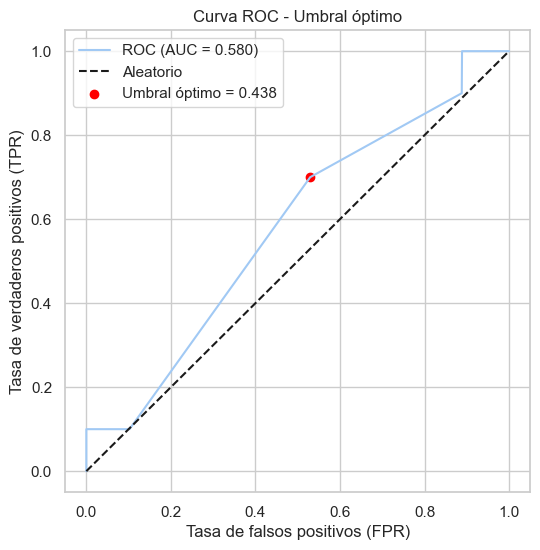

In [365]:
from sklearn.metrics import roc_curve, auc

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# Calcular el umbral óptimo (maximiza TPR - FPR)
umbral_optimo = thresholds[np.argmax(tpr - fpr)]
print(f"🔹 Umbral óptimo encontrado: {umbral_optimo:.3f}")

# Graficar curva ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--", label="Aleatorio")
plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], 
            color="red", label=f"Umbral óptimo = {umbral_optimo:.3f}")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curva ROC - Umbral óptimo")
plt.legend()
plt.show()

In [366]:
# Predicciones usando el umbral óptimo
y_pred_opt = (probs >= umbral_optimo).astype(int)

print("\n✅ MATRIZ DE CONFUSIÓN (umbral óptimo)")
print(confusion_matrix(y_test, y_pred_opt))
print("\nREPORTE DE CLASIFICACIÓN (umbral óptimo)")
print(classification_report(y_test, y_pred_opt))


✅ MATRIZ DE CONFUSIÓN (umbral óptimo)
[[723 814]
 [  3   7]]

REPORTE DE CLASIFICACIÓN (umbral óptimo)
              precision    recall  f1-score   support

           0       1.00      0.47      0.64      1537
           1       0.01      0.70      0.02        10

    accuracy                           0.47      1547
   macro avg       0.50      0.59      0.33      1547
weighted avg       0.99      0.47      0.63      1547



7.2.4. Umbral que maximiza el F1 Score

In [367]:
from sklearn.metrics import precision_recall_curve

# Calculamos las probabilidades predichas del modelo
# (usa la variable que ya tengas, por ejemplo "probs")
prec, rec, thresholds = precision_recall_curve(y_test, probs)

# Calculamos el F1-score para cada umbral posible
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)

# Identificamos el umbral que maximiza el F1
umbral_f1_optimo = thresholds[np.argmax(f1_scores)]
print(f"🔹 Umbral que maximiza F1-score: {umbral_f1_optimo:.3f}")
print(f"🔹 F1-score máximo alcanzado: {np.max(f1_scores):.3f}")

🔹 Umbral que maximiza F1-score: 0.599
🔹 F1-score máximo alcanzado: 0.182


In [368]:
# --- Evaluación del modelo con ese umbral ---
y_pred_opt = (probs >= umbral_f1_optimo).astype(int)

In [369]:
print("\n✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)")
print(confusion_matrix(y_test, y_pred_opt))

print("\n📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)")
print(classification_report(y_test, y_pred_opt))


✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)
[[1537    0]
 [   9    1]]

📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1537
           1       1.00      0.10      0.18        10

    accuracy                           0.99      1547
   macro avg       1.00      0.55      0.59      1547
weighted avg       0.99      0.99      0.99      1547



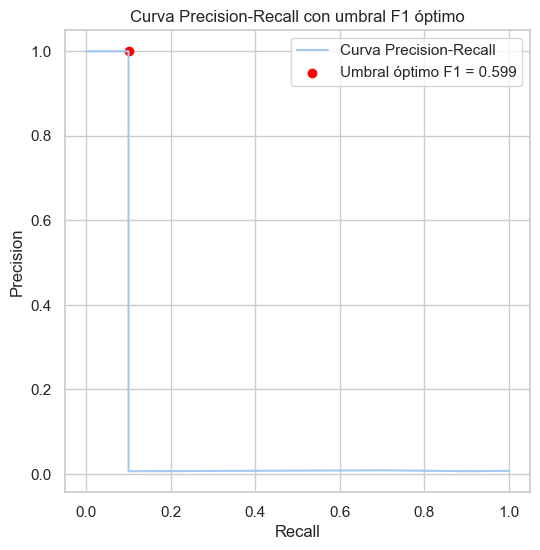

In [370]:
plt.figure(figsize=(6,6))
plt.plot(rec, prec, label="Curva Precision-Recall")
plt.scatter(rec[np.argmax(f1_scores)], prec[np.argmax(f1_scores)],
            color="red", label=f"Umbral óptimo F1 = {umbral_f1_optimo:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall con umbral F1 óptimo")
plt.legend()
plt.show()

MODELOS CON MÁS VARIABLES

In [371]:
df_modelo = df2[[
    "FechaSeguimiento_DT", 
    "Causa_DS", 
    "AgenteGenerador_DS", 
    "Severidad_NUM", 
    "valor_acumulado", 
    "materializado_30d"
]].copy()

In [372]:
# --- 2. Variables temporales ---
df_modelo["FechaSeguimiento_DT"] = pd.to_datetime(df_modelo["FechaSeguimiento_DT"])
df_modelo["mes"] = df_modelo["FechaSeguimiento_DT"].dt.month
df_modelo["anio"] = df_modelo["FechaSeguimiento_DT"].dt.year

In [373]:
# --- 3. Codificación de variables categóricas ---
le_causa = LabelEncoder()
le_agente = LabelEncoder()

df_modelo["Causa_DS"] = le_causa.fit_transform(df_modelo["Causa_DS"].astype(str))
df_modelo["AgenteGenerador_DS"] = le_agente.fit_transform(df_modelo["AgenteGenerador_DS"].astype(str))

In [374]:
# --- 4. Variables finales ---
X_2 = df_modelo[[
    "Causa_DS", 
    "AgenteGenerador_DS", 
    "mes", 
    "anio", 
    "Severidad_NUM", 
    "valor_acumulado"
]]
y_2 = df_modelo["materializado_30d"]

In [375]:
# --- 5. División de datos ---
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(
    X_2, y_2, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_2  # mantiene la proporción de clases
)

print("Tamaño entrenamiento:", X_train_2.shape)
print("Tamaño prueba:", X_test_2.shape)
print("Distribución en y_train_2:")
print(y_train_2.value_counts(normalize=True))

Tamaño entrenamiento: (6188, 6)
Tamaño prueba: (1547, 6)
Distribución en y_train_2:
materializado_30d
0    0.993536
1    0.006464
Name: proportion, dtype: float64


8. Random Forest

In [376]:
# --- 6. Entrenar Random Forest con balanceo ---
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
    max_depth=None,
    min_samples_leaf=2
)
rf.fit(X_train_2, y_train_2)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [377]:
probs_rf = rf.predict_proba(X_test_2)[:, 1]

In [378]:
# --- 8. Umbral óptimo por curva ROC ---
fpr, tpr, thresholds = roc_curve(y_test_2, probs_rf)
roc_auc = auc(fpr, tpr)

umbral_roc = thresholds[np.argmax(tpr - fpr)]
print(f"\n🔹 Umbral óptimo ROC = {umbral_roc:.3f}")


🔹 Umbral óptimo ROC = 0.021


In [379]:
# --- 9. Umbral óptimo por F1 ---
precision, recall, thresholds_f1 = precision_recall_curve(y_test_2, probs_rf)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
umbral_f1 = thresholds_f1[np.argmax(f1_scores)]
print(f"🔹 Umbral óptimo F1 = {umbral_f1:.3f}")

🔹 Umbral óptimo F1 = 0.612


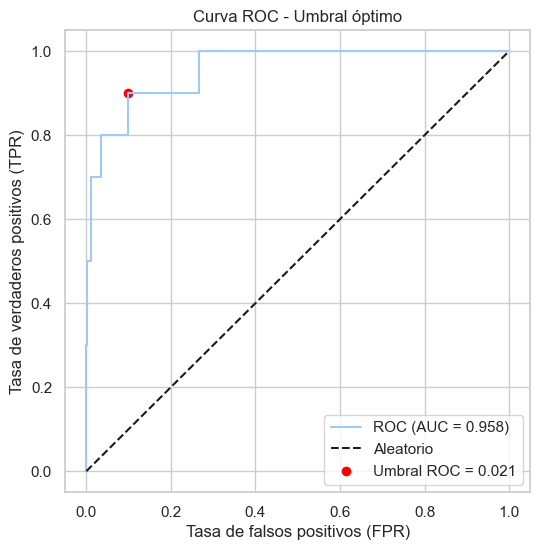

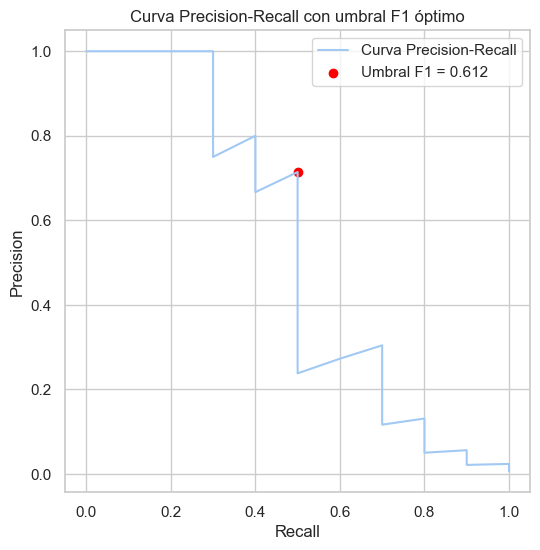

In [380]:
# --- 10. Gráficos de curvas ---
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--', label="Aleatorio")
plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], 
            color='red', label=f"Umbral ROC = {umbral_roc:.3f}")
plt.title("Curva ROC - Umbral óptimo")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.legend()
plt.show()

plt.figure(figsize=(6,6))
plt.plot(recall, precision, label="Curva Precision-Recall")
plt.scatter(recall[np.argmax(f1_scores)], precision[np.argmax(f1_scores)], 
            color='red', label=f"Umbral F1 = {umbral_f1:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall con umbral F1 óptimo")
plt.legend()
plt.show()

In [381]:
# --- 11. Predicciones con umbral F1 óptimo ---
y_pred_opt2 = (probs_rf >= umbral_f1).astype(int)

In [382]:
print("\n✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)")
print(confusion_matrix(y_test_2, y_pred_opt2))

print("\n📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)")
print(classification_report(y_test_2, y_pred_opt2))


✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)
[[1535    2]
 [   5    5]]

📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1537
           1       0.71      0.50      0.59        10

    accuracy                           1.00      1547
   macro avg       0.86      0.75      0.79      1547
weighted avg       0.99      1.00      1.00      1547



In [383]:
verdaderos_positivos = np.sum((y_pred_opt2 == 1) & (y_test_2 == 1))
total_positivos = np.sum(y_test_2 == 1)
tasa_deteccion_temprana = (verdaderos_positivos / total_positivos) * 100
print(f"Tasa de detección temprana: {tasa_deteccion_temprana:.2f}%")

Tasa de detección temprana: 50.00%


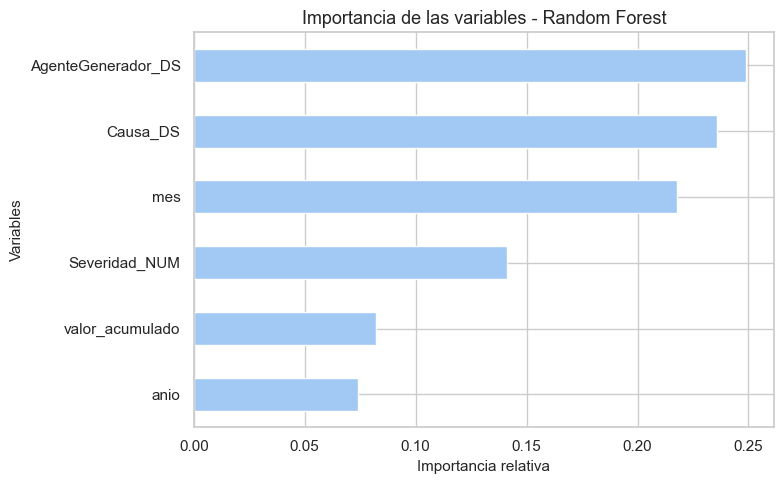

In [384]:
importances_rf = pd.Series(rf.feature_importances_, index=X_2.columns)
importances_rf.sort_values(ascending=True).plot(
    kind='barh', 
    figsize=(8, 5)
)

plt.title("Importancia de las variables - Random Forest", fontsize=13)
plt.xlabel("Importancia relativa", fontsize=11)
plt.ylabel("Variables", fontsize=11)
plt.tight_layout()
plt.show()

In [385]:
#Guardar el modelo

import joblib
joblib.dump(rf, "modelo_rf_materializacion.pkl")

['modelo_rf_materializacion.pkl']

9. Modelo GBoost

In [386]:
df_gb = df_modelo.copy()

In [387]:
le_causa = LabelEncoder()
le_agente = LabelEncoder()

In [388]:
df_gb["Causa_DS"] = le_causa.fit_transform(df_gb["Causa_DS"].astype(str))
df_gb["AgenteGenerador_DS"] = le_agente.fit_transform(df_gb["AgenteGenerador_DS"].astype(str))


In [389]:
from sklearn.ensemble import GradientBoostingClassifier

modelo_gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
modelo_gb.fit(X_train_2, y_train_2)

,loss,'log_loss'
,learning_rate,0.05
,n_estimators,300
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [390]:
probs_gb = modelo_gb.predict_proba(X_test_2)[:, 1]

In [391]:
fpr, tpr, thresholds = roc_curve(y_test_2, probs_gb)
roc_auc = auc(fpr, tpr)

# Umbral óptimo (maximiza TPR - FPR)
umbral_optimo = thresholds[np.argmax(tpr - fpr)]
print(f"🔹 Umbral óptimo encontrado: {umbral_optimo:.3f}")

🔹 Umbral óptimo encontrado: 0.004


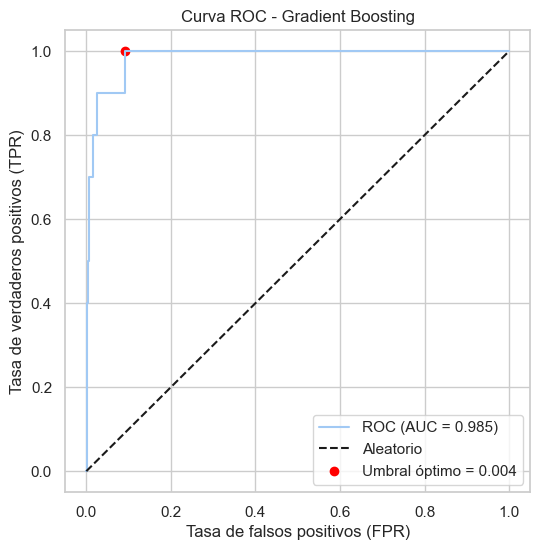

In [392]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--", label="Aleatorio")
plt.scatter(fpr[np.argmax(tpr - fpr)], tpr[np.argmax(tpr - fpr)], 
            color="red", label=f"Umbral óptimo = {umbral_optimo:.3f}")
plt.xlabel("Tasa de falsos positivos (FPR)")
plt.ylabel("Tasa de verdaderos positivos (TPR)")
plt.title("Curva ROC - Gradient Boosting")
plt.legend()
plt.show()

In [393]:
pred_opt_gb = (probs_gb >= umbral_optimo).astype(int)

In [394]:
print("\n✅ MATRIZ DE CONFUSIÓN (umbral óptimo)")
print(confusion_matrix(y_test_2, pred_opt_gb))

print("\n📊 REPORTE DE CLASIFICACIÓN (umbral óptimo)")
print(classification_report(y_test_2, pred_opt_gb))


✅ MATRIZ DE CONFUSIÓN (umbral óptimo)
[[1397  140]
 [   0   10]]

📊 REPORTE DE CLASIFICACIÓN (umbral óptimo)
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1537
           1       0.07      1.00      0.12        10

    accuracy                           0.91      1547
   macro avg       0.53      0.95      0.54      1547
weighted avg       0.99      0.91      0.95      1547



In [395]:
import joblib
joblib.dump(modelo_gb, "modelo_gradientboosting.pkl")

['modelo_gradientboosting.pkl']

8.1. Mejor tradeoff

🔹 Umbral con mejor F1-score: 0.403
🔹 F1 máximo alcanzado: 0.533


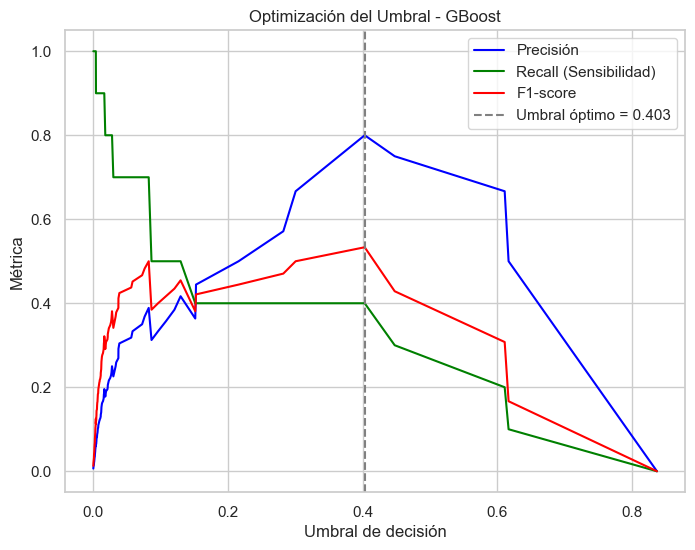

In [396]:
# Probabilidades predichas por el modelo
probs_gb = modelo_gb.predict_proba(X_test_2)[:, 1]

# Calcular precisión, recall y umbrales
precision, recall, thresholds = precision_recall_curve(y_test_2, probs_gb)

# Calcular F1 para cada umbral
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

# Encontrar el umbral con el F1 máximo
umbral_f1_optimo = thresholds[np.argmax(f1_scores)]
print(f"🔹 Umbral con mejor F1-score: {umbral_f1_optimo:.3f}")
print(f"🔹 F1 máximo alcanzado: {np.max(f1_scores):.3f}")

# Graficar curvas
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label="Precisión", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall (Sensibilidad)", color="green")
plt.plot(thresholds, f1_scores[:-1], label="F1-score", color="red")
plt.axvline(x=umbral_f1_optimo, color="gray", linestyle="--", label=f"Umbral óptimo = {umbral_f1_optimo:.3f}")
plt.xlabel("Umbral de decisión")
plt.ylabel("Métrica")
plt.title("Optimización del Umbral - GBoost")
plt.legend()
plt.grid(True)
plt.show()

Usaremos el umbral óptimo 0.4

In [397]:
# 🔹 Probabilidades predichas por el modelo GBoost
probs_gb = modelo_gb.predict_proba(X_test_2)[:, 1]

# 🔹 Aplicar el umbral óptimo
umbral_optimo = 0.403
pred_opt2_gb = (probs_gb >= umbral_optimo).astype(int)

# 🔹 Calcular matriz de confusión y reporte
matriz_gb = confusion_matrix(y_test_2, pred_opt2_gb)
reporte_gb = classification_report(y_test_2, pred_opt2_gb, digits=3)

# 🔹 Mostrar resultados
print("✅ MATRIZ DE CONFUSIÓN (umbral óptimo = 0.403)")
print(matriz_gb)
print("\n📊 REPORTE DE CLASIFICACIÓN (umbral óptimo = 0.403)")
print(reporte_gb)

✅ MATRIZ DE CONFUSIÓN (umbral óptimo = 0.403)
[[1536    1]
 [   7    3]]

📊 REPORTE DE CLASIFICACIÓN (umbral óptimo = 0.403)
              precision    recall  f1-score   support

           0      0.995     0.999     0.997      1537
           1      0.750     0.300     0.429        10

    accuracy                          0.995      1547
   macro avg      0.873     0.650     0.713      1547
weighted avg      0.994     0.995     0.994      1547



In [398]:
df_modelo["Riesgo_CD"] = df2["Riesgo_CD"].values

In [399]:
resultados_rf = pd.DataFrame({
    "Riesgo_CD": df_modelo.loc[y_test_2.index, "Riesgo_CD"],
    "Prob_Materializacion": probs_rf,
    "Predicho_Materializado": y_pred_opt2,   # usa el nombre correcto de tus predicciones
    "Real_Materializado": y_test_2.values
})

# --- Guardar resultados ---
resultados_rf.to_excel("Predicciones_Modelo_RF_optimo.xlsx", index=False)
print("✅ Archivo 'Predicciones_Modelo_RF_optimo.xlsx' creado exitosamente.")

✅ Archivo 'Predicciones_Modelo_RF_optimo.xlsx' creado exitosamente.


9. Modelo XGBoost

In [400]:
X_train_xgb = X_train_2.copy()
X_test_xgb = X_test_2.copy()

In [401]:
# Convertir columnas categóricas a códigos numéricos
X_train_xgb = X_train_xgb.apply(lambda col: col.cat.codes if str(col.dtype) == 'category' else col)
X_test_xgb = X_test_xgb.apply(lambda col: col.cat.codes if str(col.dtype) == 'category' else col)

In [402]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=10,
    eval_metric='logloss'
)

xgb_model.fit(X_train_xgb, y_train_2)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [403]:
probs_xgb = xgb_model.predict_proba(X_test_xgb)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_2, probs_xgb)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

umbral_f1_optimo = thresholds[np.argmax(f1_scores)]
f1_maximo = np.max(f1_scores)

print(f"🔹 Umbral con mejor F1-score: {umbral_f1_optimo:.3f}")
print(f"🔹 F1 máximo alcanzado: {f1_maximo:.3f}")

🔹 Umbral con mejor F1-score: 0.688
🔹 F1 máximo alcanzado: 0.556


In [404]:
pred_opt_xgb = (probs_xgb >= umbral_f1_optimo).astype(int)

matriz_xgb = confusion_matrix(y_test_2, pred_opt_xgb)
reporte_xgb = classification_report(y_test_2, pred_opt_xgb, digits=3)

print("\n✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)")
print(matriz_xgb)

print("\n📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)")
print(reporte_xgb)


✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)
[[1534    3]
 [   5    5]]

📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)
              precision    recall  f1-score   support

           0      0.997     0.998     0.997      1537
           1      0.625     0.500     0.556        10

    accuracy                          0.995      1547
   macro avg      0.811     0.749     0.776      1547
weighted avg      0.994     0.995     0.995      1547



In [405]:
# Crear DataFrame con las predicciones y probabilidades
resultados_xgb = pd.DataFrame({
    "Riesgo_CD": df_modelo.loc[y_test_2.index, "Riesgo_CD"],
    "Prob_Materializacion": probs_xgb,
    "Predicho_Materializado": pred_opt_xgb,
    "Real_Materializado": y_test_2.values
})

In [406]:
nombre_archivo = "Predicciones_Modelo_XGBoost_optimo.xlsx"
resultados_xgb.to_excel(nombre_archivo, index=False)

print(f"✅ Archivo '{nombre_archivo}' creado exitosamente.")

✅ Archivo 'Predicciones_Modelo_XGBoost_optimo.xlsx' creado exitosamente.


10. Modelo lightgbm con encoding interno

In [407]:
categorical_features = ["Causa_DS", "AgenteGenerador_DS"]

In [408]:
from lightgbm import LGBMClassifier

lgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight="balanced"
)

lgbm_model.fit(
    X_train_2, y_train_2,
    categorical_feature=categorical_features
)

[LightGBM] [Info] Number of positive: 40, number of negative: 6148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 6188, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [409]:
probs_lgbm = lgbm_model.predict_proba(X_test_2)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_2, probs_lgbm)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

umbral_f1_optimo = thresholds[np.argmax(f1_scores)]
print(f"🔹 Umbral F1 óptimo: {umbral_f1_optimo:.3f}")
print(f"🔹 F1 máximo: {np.max(f1_scores):.3f}")

🔹 Umbral F1 óptimo: 0.744
🔹 F1 máximo: 0.286


In [410]:
pred_opt_lgbm = (probs_lgbm >= umbral_f1_optimo).astype(int)

In [411]:
matriz_lgbm = confusion_matrix(y_test_2, pred_opt_lgbm)
reporte_lgbm = classification_report(y_test_2, pred_opt_lgbm, digits=3)

print("\n✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)")
print(matriz_lgbm)
print("\n📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)")
print(reporte_lgbm)


✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)
[[1529    8]
 [   7    3]]

📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)
              precision    recall  f1-score   support

           0      0.995     0.995     0.995      1537
           1      0.273     0.300     0.286        10

    accuracy                          0.990      1547
   macro avg      0.634     0.647     0.640      1547
weighted avg      0.991     0.990     0.991      1547



11. Modelo ligthgbm usando label encoding

In [412]:
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    class_weight="balanced"
)

lgbm.fit(X_train_2, y_train_2)

[LightGBM] [Info] Number of positive: 40, number of negative: 6148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 78
[LightGBM] [Info] Number of data points in the train set: 6188, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [413]:
probs2_lgbm = lgbm.predict_proba(X_test_2)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test_2, probs2_lgbm)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)

umbral_f1_optimo = thresholds[np.argmax(f1_scores)]
print(f"🔹 Umbral F1 óptimo: {umbral_f1_optimo:.3f}")
print(f"🔹 F1 máximo: {np.max(f1_scores):.3f}")

🔹 Umbral F1 óptimo: 0.696
🔹 F1 máximo: 0.455


In [414]:
pred_opt_lgbm2 = (probs2_lgbm >= umbral_f1_optimo).astype(int)

In [415]:
matriz_lgbm2 = confusion_matrix(y_test_2, pred_opt_lgbm2)
reporte_lgbm2 = classification_report(y_test_2, pred_opt_lgbm2, digits=3)

print("\n✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)")
print(matriz_lgbm2)
print("\n📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)")
print(reporte_lgbm2)


✅ MATRIZ DE CONFUSIÓN (umbral F1 óptimo)
[[1530    7]
 [   5    5]]

📊 REPORTE DE CLASIFICACIÓN (umbral F1 óptimo)
              precision    recall  f1-score   support

           0      0.997     0.995     0.996      1537
           1      0.417     0.500     0.455        10

    accuracy                          0.992      1547
   macro avg      0.707     0.748     0.725      1547
weighted avg      0.993     0.992     0.993      1547

